# Data Plotting

This notebook provides a tutorial for plotting the output of tidy3d simulations.

In [1]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 100

import numpy as np
import matplotlib.pylab as plt

import sys
sys.path.append('../')

import tidy3d as td
import tidy3d_core as tdcore

## Setup

### Creating Simulation

First, let's make a `td.Simulation` so we have data to plot.

In [2]:
# make samplers that define the freq and time domain measurement
freqs = td.uniform_freq_sampler(f_start=5, f_stop=10, num_freqs=51)
times = td.uniform_time_sampler(t_start=0, t_stop=100, t_step=1)

num_modes = 3

simulation = td.Simulation(
    size=(5.0, 5.0, 5.0),
    grid_size=(0.1, 0.1, 0.1),
    structures = [
        td.Structure(
            geometry=td.Box(center=(-1,0,0), size=(.6,.6,.6)),
            medium=td.Medium(permittivity=2)
        ),
        td.Structure(
            geometry=td.Box(center=(1,0,0), size=(.6,.6,.6)),
            medium=td.Medium(permittivity=2)
        )        
    ],
    monitors={
        "field": td.FieldMonitor(
            size=(3,3,3),
            center=(0,0,0),
            freqs=freqs),
        "field_time": td.FieldTimeMonitor(
            size=(3,3,3),
            center=(0,0,0),
            times=times),
        "permittivity": td.PermittivityMonitor(
            size=(3,3,3),
            center=(0,0,0),
            freqs=freqs),
        "flux": td.FluxMonitor(
            size=(1,1,0),
            center=(0,0,0),
            freqs=freqs),
        "flux_time": td.FluxTimeMonitor(
            size=(1,1,0),
            center=(0,0,0),
            times=times),
        "mode": td.ModeMonitor(
            size=(1,1,0),
            center=(0,0,0),
            freqs=freqs,
            modes=[td.Mode(mode_index=i) for i in range(num_modes)])
    },
)

### Running Simulation

This is technically what would be done through webAPI.

For simplicity calling `tidy3d_core` (backend) directly to do it here with some generated data.


`tdcore.solve()` takes a `td.Simulation` and returns dictionary of `{monitor_name (str): monitor_data_dict (dict)}`

`monitor_data_dict` is just a dictionary of `{data_name (str): data_value (Numpy)}`

where `data_name=data`is reserved for the raw data and the other keys are coordinates (`xs`, `ys`, `zs`, `mode_index`, `freqs`, etc)

In [3]:
solver_data_dict = tdcore.solve(simulation)

### Loading Results into Simulation and Monitor data
`tdcore.load_solver_results()` takes the solver_data_dict and the original simulation and returns an instance of `td.SimulationData`
    
`td.SimulationData.monitor_data` is a dictionary of `{monitor_name (str): monitor_data (td.MonitorData)}`
    
Each `td.Monitor` in the `td.SimulationData.monitor_data` dictionary has a corresponding `td.MonitorData` that holds the data and contains various methods like `.plot()`, `.export()`, `.load()`.

Additionally, the `.data` attribute of `td.Monitor` holds an `xarray.DataArray` representation of the data, which provides several functionalties, such as selecting index by label and interpolation.  See [here](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.html) for a comprehensive list.

In [4]:
sim_data = tdcore.load_solver_results(simulation=simulation, solver_data_dict=solver_data_dict)

## Plotting

Here we show how to plot data from each monitor

### Flux Data

`td.FluxData` and `td.FluxTimeData` is the simplest because it just stores the electromagnetic power flux through a surface as a function of the frequency and time, respectively.

First, we access the `td.MonitorData` through the dictionary `sim_data.monitor_data`.

In [5]:
# get the flux data from that monitor name
flux_data = sim_data.monitor_data['flux']
flux_time_data = sim_data.monitor_data['flux_time']

and we can plot the values using the `td.MonitorData.plot()` method.

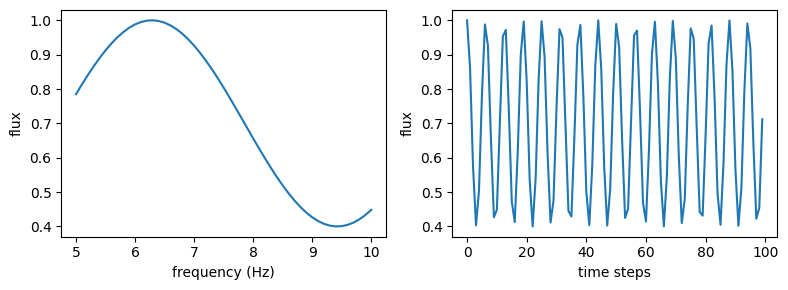

In [6]:
f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(8,3))
flux_data.plot(ax=ax1)
flux_time_data.plot(ax=ax2)

plt.show()

## Plotting Mode Data

The axes of mode data correspond to direction (+/-), mode_index, and sampler axes. 

To pot all of this data, we make two subplots and use the builting `.sel()` function to select the data to plot in each axis.

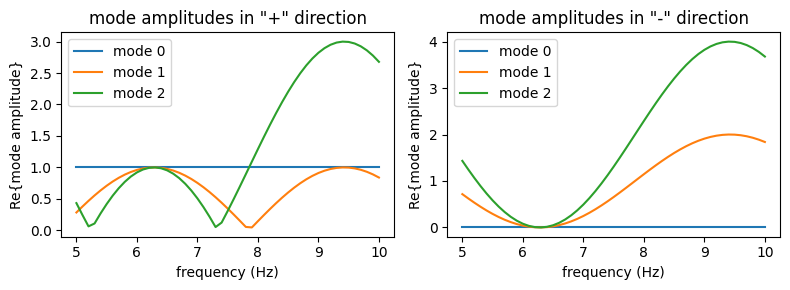

In [7]:
# tip: you can also get the monitor data directly by indexing it's name in `SimulationData`
mode_data = sim_data.monitor_data['mode']

f, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(8, 3))

ax1 = mode_data.plot(direction='+', ax=ax1)
ax2 = mode_data.plot(direction='-', ax=ax2)
ax1.set_title('mode amplitudes in "+" direction')
ax2.set_title('mode amplitudes in "-" direction')
plt.show()


### Plotting Fields

To plot field data, we must specify the `position` and `axis (0,1,2)` of the plane we wish to plot, as well as the frequency or time value in the data.

To start, let's plot the permittivity data.

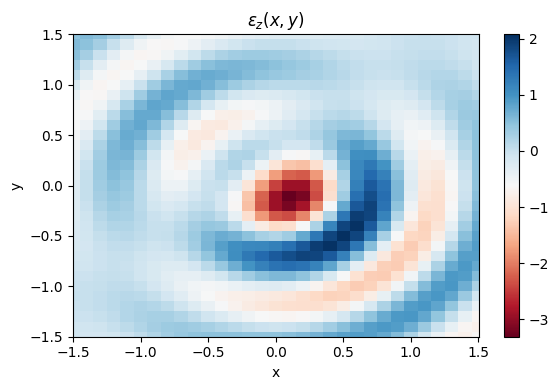

In [8]:
eps_data = sim_data.monitor_data['permittivity']
ax = eps_data.plot(field_name='epsilon_x', position=0.4, axis=2, freq=7.5)
ax.set_title(r'$\epsilon_{z}(x,y)$')
plt.show()

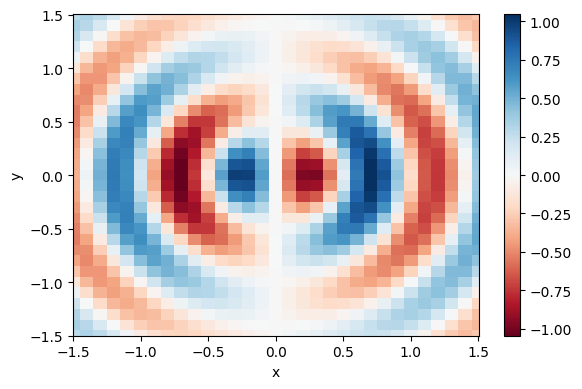

In [9]:
field_data = sim_data.monitor_data['field']
field_data.plot(field_name='Ex', freq=7.5, position=0.4, axis=2)
plt.show()

One can overlay the structure permittivity by calling `plot_fields` from the `td.SimulationData` object as follows:

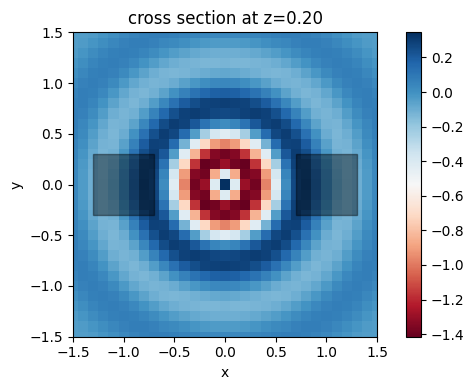

In [10]:
ax = sim_data.plot_fields('field', field_name='Ez', freq=7.5, position=0.2, axis=2)

## Tricks and Tips

The `SimulationData.plot()` method can be used to call any of the `td.MonitorData.plot()` methods directly by passing the monitor name.

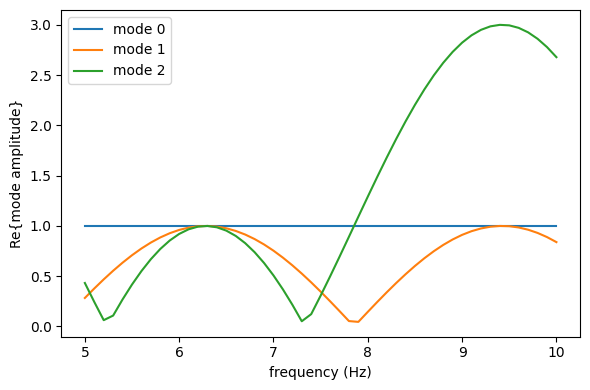

In [11]:
ax = sim_data.plot('mode', direction='+')
plt.show()

The `td.MonitorData` objects can be found by indexing `td.SimulationData` directly.

In [12]:
sim_data.monitor_data['mode'] == sim_data['mode']

True

Keyword arguments are passed to the correponding `.plot()` calls internally, so you can customize the plots.

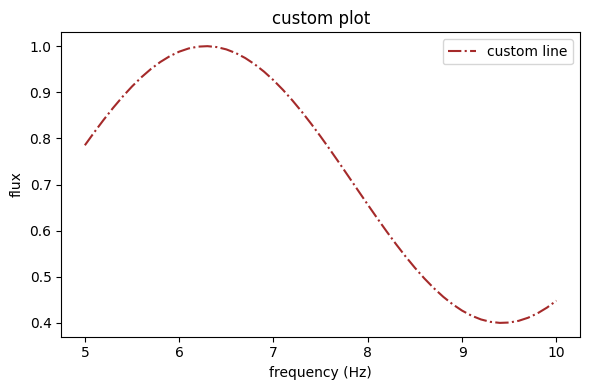

In [13]:
ax = sim_data['flux'].plot(color='brown', linestyle='-.', label='custom line')
ax.legend()
ax.set_title('custom plot')
plt.show()